In [59]:
from brnn_model_fake_data import *
import reader

import subprocess
import tensorflow as tf
import import_folders
import pickle_lib as pkl
from graph_lib import gl

In [60]:
"""
    Global variables
"""
model_type = "test"
data_path = "../data/"
save_path = "./saved_model/"
global_prior_pi = 0.25
global_log_sigma1 = -1.0
global_log_sigma2 = -7.0
global_random_seed = 12
global_num_gpus = 0


# Model can be "test", "small", "medium", "large"
model_select = "test"
model_type = model_select
#Put the path to the data here
dat_path = "../data"

#Put the path to where you want to save the training data
sav_path = "tensorboard/"

# The mixing degree for the prior gaussian mixture
# As in Fortunato they report scanning
# mix_pi \in { 1/4, 1/2, 3/4 }
mixing_pi = 0.25

# As in Fortunato they report scanning
# log sigma1 \in { 0, -1, -2 }
# log sigma2 \in { -6, -7, -8 }
prior_log_sigma1 = -1.0
prior_log_sigma2 = -7.0


class SmallConfig(object):
    """Small config."""
    init_scale = 0.1
    learning_rate = 1.0
    max_grad_norm = 5
    num_layers = 2
    num_steps = 20
    hidden_size = 200
    max_epoch = 4
    max_max_epoch = 13
    keep_prob = 1.0
    lr_decay = 0.5
    
    batch_size = 20
    vocab_size = 10000
    
    X_dim = 200 # Size of the embedding

class MediumConfig(object):
    """
    Medium config.
    Slightly modified according to email.
    """
    init_scale = 0.05
    learning_rate = 1.0
    max_grad_norm = 5
    num_layers = 2
    num_steps = 35
    hidden_size = 650
    max_epoch = 20
    max_max_epoch = 70
    keep_prob = 1.0
    lr_decay = 0.9
    batch_size = 20
    vocab_size = 10000

    X_dim = 50 # Size of the embedding
    
class LargeConfig(object):
    """Large config."""
    init_scale = 0.04
    learning_rate = 1.0
    max_grad_norm = 10
    num_layers = 2
    num_steps = 35
    hidden_size = 1500
    max_epoch = 14
    max_max_epoch = 55
    keep_prob = 0.35
    lr_decay = 1 / 1.15
    batch_size = 20
    vocab_size = 10000

    X_dim = 100 # Size of the embedding
    
class TestConfig(object):
    """Tiny config, for testing."""
    init_scale = 0.1
    learning_rate = 1.0
    max_grad_norm = 1
    num_layers = 2
    num_steps = 20
    hidden_size = 15
    max_epoch = 10
    max_max_epoch = 20
    keep_prob = 1.0
    lr_decay = 0.5
    batch_size = 13
    
    vocab_size = 10000

    X_dim = 19 # Size of the embedding


#    global_random_seed = set_random_seed
    
def get_config():
    """Get model config."""
    if model_type == "small":
        config = SmallConfig()
    elif model_type == "medium":
        config = MediumConfig()
    elif model_type == "large":
        config = LargeConfig()
    elif model_type == "test":
        config = TestConfig()
    else:
        raise ValueError("Invalid model: %s", model_type)

    print ("Model Type")
    print (model_type)
    config.prior_pi = global_prior_pi
    config.log_sigma1 = global_log_sigma1
    config.log_sigma2 = global_log_sigma2

    return config

In [61]:

print (model_type)

####### Global data reading #########
Ndivisions = 10;
folder_data = "./data/artificial/"

X_list = pkl.load_pickle(folder_data +"X_values.pkl",Ndivisions)
Y_list = pkl.load_pickle(folder_data +"Y_values.pkl",Ndivisions)

num_steps, X_dim = X_list[0].shape
num_chains = len(X_list)


## Divide in train val and test
proportion_tr = 0.8
proportion_val = 0.1
proportion_tst = 1 -( proportion_val + proportion_tr)

num_tr = 10000
num_val = 5000
num_tst = 5000

train_X = [X_list[i] for i in range(num_tr)]
train_Y = [Y_list[i] for i in range(num_tr)]

val_X = [X_list[i] for i in range(num_tr, num_tr + num_val)]
val_Y = [Y_list[i] for i in range(num_tr, num_tr + num_val)]

tst_X = [X_list[i] for i in range(num_tr + num_val,  num_tr + num_val + num_tst)]
tst_Y = [Y_list[i] for i in range(num_tr + num_val,  num_tr + num_val + num_tst)]

# Create the objects with the hyperparameters that will be fed to the network
train_config = get_config()
eval_config = get_config( )

###### Over Set parameters #####
train_config.X_dim  = X_dim
eval_config.X_dim  = X_dim
train_config.num_steps  = num_steps
eval_config.num_steps  = num_steps

train_config.vocab_size = 2
eval_config.vocab_size= 2


eval_config.batch_size = 2
    
#eval_config.num_steps = 1

print ("Number of total initial chains %i"%len(X_list))
print ("Dimensionality of chains (num_step,X_dim)",X_list[0].shape )


test
Model Type
test
Model Type
test
Number of total initial chains 20000
Dimensionality of chains (num_step,X_dim) (20, 1)


In [68]:

#subprocess.Popen(["tensorboard","--logdir=tensorboard"])

with tf.Graph().as_default():
    initializer = tf.random_uniform_initializer(-train_config.init_scale,
                                                train_config.init_scale)

    with tf.name_scope("Train"):
        train_input = BBB_LSTM_Artificial_Data_Input(batch_size = train_config.batch_size, 
                                                        X = train_X, Y = train_Y,  name="TrainInput")
        
        with tf.variable_scope("Model", reuse=None, initializer=initializer):
            m = PTBModel(is_training=True, config=train_config, input_=train_input)
        tf.summary.scalar("Training_Loss", m.cost)
        tf.summary.scalar("Learning_Rate", m.lr)
        tf.summary.scalar("KL Loss", m.kl_loss)
        tf.summary.scalar("Total Loss", m.total_loss)

    print ("Creating Validation model")
    with tf.name_scope("Valid"):
        valid_input = BBB_LSTM_Artificial_Data_Input(batch_size = eval_config.batch_size, 
                                                            X = val_X, Y = val_Y,  name="ValidInput")
        
        with tf.variable_scope("Model", reuse=True, initializer=initializer):
            mvalid = PTBModel(is_training=False, config=eval_config, input_=valid_input)
        tf.summary.scalar("Validation_Loss", mvalid.cost)

    with tf.name_scope("Test"):
        test_input = BBB_LSTM_Artificial_Data_Input(batch_size = eval_config.batch_size, 
                                                            X = tst_X, Y = tst_Y,  name="TestInput")
            
        with tf.variable_scope("Model", reuse=True, initializer=initializer):
            mtest = PTBModel(is_training=False, config=eval_config,
                             input_=test_input)

    models = {"Train": m, "Valid": mvalid, "Test": mtest}
    for name, model in models.items():
        model.export_ops(name)
    metagraph = tf.train.export_meta_graph()
    soft_placement = False
    if global_num_gpus > 1:
        soft_placement = True
        util.auto_parallel(metagraph, m)


INFO:tensorflow:Summary name KL Loss is illegal; using KL_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Creating Validation model


In [69]:

## Training !
with tf.Graph().as_default():
    tf.train.import_meta_graph(metagraph)
    for model in models.values():
        model.import_ops()
    sv = tf.train.Supervisor(logdir=save_path)
    config_proto = tf.ConfigProto(allow_soft_placement=soft_placement)
    with sv.managed_session(config=config_proto) as session:

        for i in range(train_config.max_max_epoch):
            lr_decay = train_config.lr_decay ** max(i + 1 - train_config.max_epoch, 0.0)
            m.assign_lr(session, train_config.learning_rate * lr_decay)

            print("Epoch: %d Learning rate: %.3f" % (i + 1, session.run(m.lr)))
            train_perplexity = run_epoch(session, m, eval_op=m.train_op,
                                         verbose=True)
            print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))
            valid_perplexity = run_epoch(session, mvalid)
            print("Epoch: %d Valid Perplexity: %.3f" % (i + 1, valid_perplexity))
            
        test_perplexity = run_epoch(session, mtest)
        print("Test Perplexity: %.3f" % test_perplexity)
        

        print("Saving model to %s." % save_path)
        sv.saver.save(session, save_path, global_step=sv.global_step)


INFO:tensorflow:Restoring parameters from ./saved_model/model.ckpt-15380
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path ./saved_model/model.ckpt
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Recording summary at step 15380.
Epoch: 1 Learning rate: 1.000
0.000 perplexity: 1.636 speed: 621 wps
KL is 0.7773967385292053
0.013 perplexity: 1.763 speed: 5437 wps
KL is 0.7775965332984924
0.112 perplexity: 1.768 speed: 25124 wps
KL is 0.7898072004318237
0.211 perplexity: 1.777 speed: 32282 wps
KL is 0.7963449954986572
0.309 perplexity: 1.779 speed: 36694 wps
KL is 0.796751856803894
0.408 perplexity: 1.778 speed: 41081 wps
KL is 0.8025634288787842
0.507 perplexity: 1.774 speed: 43395 wps
KL is 0.8186191916465759
0.606 perplexity: 1.774 speed: 46313 wps
KL is 0.8217758536338806
0.705 perplexity: 1.773 speed: 48707 wps
KL is 0.8244792819023132
0.804 perplexity: 1.773 speed: 50724 wps
KL is 0.827630341053009
0.902 perplexity: 1.771 speed: 52436 wps
K

0.705 perplexity: 1.740 speed: 57817 wps
KL is 0.9584164619445801
0.804 perplexity: 1.741 speed: 58892 wps
KL is 0.9487742185592651
0.902 perplexity: 1.739 speed: 57496 wps
KL is 0.960096538066864
Epoch: 10 Train Perplexity: 1.739
Epoch: 10 Valid Perplexity: 1.721
Epoch: 11 Learning rate: 0.500
0.000 perplexity: 1.629 speed: 24165 wps
KL is 0.9586028456687927
0.013 perplexity: 1.706 speed: 35557 wps
KL is 0.9534433484077454
0.112 perplexity: 1.684 speed: 48733 wps
KL is 0.948199987411499
0.211 perplexity: 1.687 speed: 57289 wps
KL is 0.946067214012146
0.309 perplexity: 1.688 speed: 55083 wps
KL is 0.9512524604797363
0.408 perplexity: 1.685 speed: 55401 wps
KL is 0.9429378509521484
0.507 perplexity: 1.682 speed: 56357 wps
KL is 0.9436895847320557
0.606 perplexity: 1.682 speed: 56702 wps
KL is 0.9380713701248169
0.705 perplexity: 1.682 speed: 57171 wps
KL is 0.9313299059867859
0.804 perplexity: 1.683 speed: 56559 wps
KL is 0.9345520734786987
0.902 perplexity: 1.681 speed: 58107 wps
KL is

0.606 perplexity: 1.648 speed: 73803 wps
KL is 0.8992413878440857
0.705 perplexity: 1.648 speed: 73625 wps
KL is 0.9047326445579529
0.804 perplexity: 1.648 speed: 73603 wps
KL is 0.8932386636734009
0.902 perplexity: 1.647 speed: 73612 wps
KL is 0.8992160558700562
Epoch: 20 Train Perplexity: 1.645
Epoch: 20 Valid Perplexity: 1.642
Test Perplexity: 1.649
Saving model to ./saved_model/.


In [70]:
## Testing
print ("Testing")
predicted = []   # Variable to store predictions
with tf.Graph().as_default():
    tf.train.import_meta_graph(metagraph)
    for model in models.values():
        model.import_ops()
    sv = tf.train.Supervisor(logdir=save_path)
    config_proto = tf.ConfigProto(allow_soft_placement=soft_placement)
    with sv.managed_session(config=config_proto) as session:
        
       # session = tf.Session()
    
        test_perplexity = run_epoch(session, mtest)
        print("Test Perplexity: %.3f" % test_perplexity)

        print ("----------------------------------------------------------------")
        print ("------------------ Prediction of Output ---------------------")

       #  inputs, predicted = fetch_output(session, mtest)

        costs = 0.0
        state = session.run(model.initial_state)

        inputs = []
        outputs = []
        targets = []
        fetches = {
            "final_state": model.final_state,
            "output": model.output,
            "input": model.input_data,
            "targets": model.targets
        }

        for step in range(model.input.epoch_size):
            feed_dict = {}
            for i, (c, h) in enumerate(model.initial_state):
                feed_dict[c] = state[i].c
                feed_dict[h] = state[i].h

            print ("Computing batch %i/%i"%(step, model.input.epoch_size))
            vals = session.run(fetches, feed_dict)
            state = vals["final_state"]
            output = vals["output"]
            input_i = vals["input"]
            
            outputs.append(output)
            inputs.append(input_i)
            targets.append(vals["targets"])
            if (step == 100):
                break;


Testing
INFO:tensorflow:Restoring parameters from ./saved_model/-30760
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path ./saved_model/model.ckpt
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Recording summary at step 30760.
Test Perplexity: 1.649
----------------------------------------------------------------
------------------ Prediction of Output ---------------------
Computing batch 0/2500
Computing batch 1/2500
Computing batch 2/2500
Computing batch 3/2500
Computing batch 4/2500
Computing batch 5/2500
Computing batch 6/2500
Computing batch 7/2500
Computing batch 8/2500
Computing batch 9/2500
Computing batch 10/2500
Computing batch 11/2500
Computing batch 12/2500
Computing batch 13/2500
Computing batch 14/2500
Computing batch 15/2500
Computing batch 16/2500
Computing batch 17/2500
Computing batch 18/2500
Computing batch 19/2500
Computing batch 20/2500
Computing batch 21/2500
Computing batch 22/2500
Computing batch 23/2500
Computing bat

In [71]:
print ("Input and output of the first chain of the first batch")
print (inputs[0][0])

print("Soft Outputs")
print (outputs[0][0])
print("Hard Outputs")
selected_words = np.argmax(outputs[0][0], axis = 1)
print (selected_words)
print("targets")
print (targets[0][0])

print ("Prob of -1")
print (np.array(inputs[0][0])[:,0])

Input and output of the first chain of the first batch
[[-0.35387513]
 [-0.13013525]
 [-0.04220389]
 [ 0.0845343 ]
 [ 0.10315136]
 [ 0.14160155]
 [ 0.08472783]
 [ 0.35366136]
 [ 0.2438499 ]
 [ 0.13540922]
 [ 0.27223107]
 [ 0.35300788]
 [ 0.41562226]
 [ 0.40677628]
 [ 0.5052312 ]
 [ 0.52947694]
 [ 0.25754994]
 [ 0.36512345]
 [ 0.23978026]
 [ 0.2961387 ]]
Soft Outputs
[[ 0.2646448   0.73535514]
 [ 0.21113642  0.7888636 ]
 [ 0.28522581  0.71477413]
 [ 0.1810462   0.81895381]
 [ 0.1551529   0.84484714]
 [ 0.41891605  0.58108401]
 [ 0.75473732  0.2452627 ]
 [ 0.65458274  0.34541726]
 [ 0.34772551  0.65227443]
 [ 0.18422121  0.81577885]
 [ 0.0860562   0.91394383]
 [ 0.08238279  0.9176172 ]
 [ 0.07106467  0.92893529]
 [ 0.18794847  0.81205159]
 [ 0.57744163  0.42255834]
 [ 0.86168563  0.13831431]
 [ 0.95597303  0.04402693]
 [ 0.92170006  0.0782999 ]
 [ 0.73771346  0.26228657]
 [ 0.21461594  0.78538406]]
Hard Outputs
[1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1]
targets
[1 1 1 1 1 0 0 1 1 1 1 1 1 

[[-0.42529035]
 [-0.26083782]
 [-0.10237756]
 [-0.07140435]
 [ 0.17238964]
 [ 0.13738577]
 [ 0.15471777]
 [ 0.16784137]
 [ 0.06021721]
 [ 0.01813063]
 [ 0.14186417]
 [ 0.06525955]
 [ 0.30379745]
 [ 0.39280519]
 [ 0.47785646]
 [ 0.2147723 ]
 [ 0.39986274]
 [ 0.24228908]
 [ 0.011415  ]
 [ 0.09339187]]
[1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1]
[[ 0.4696407 ]
 [ 0.56500918]
 [ 0.76427066]
 [ 0.71532428]
 [ 0.9158296 ]
 [ 0.76552421]
 [ 0.31449795]
 [ 0.24485034]
 [ 0.62031317]
 [ 0.82922703]
 [ 0.89886373]
 [ 0.83758926]
 [ 0.87051845]
 [ 0.92130691]
 [ 0.73503876]
 [ 0.17447521]
 [ 0.17361833]
 [ 0.14378321]
 [ 0.19088235]
 [ 0.35673121]]


/home/montoya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


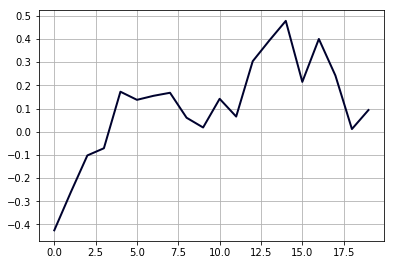

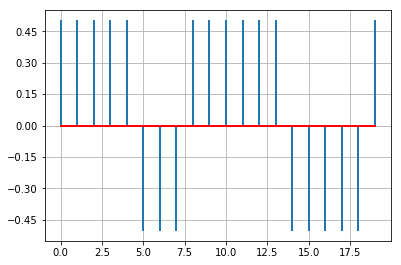

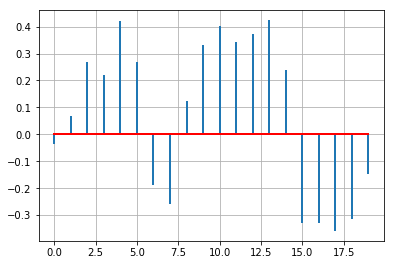

In [76]:
batch_i = 20

data = np.array(inputs[batch_i][0])[:,[0]]
labels = np.array(targets[batch_i][0])[:]
predicted = np.array(outputs[batch_i][0])[:,[1]]
print(data)
print(labels)
print (predicted)
gl.plot(np.array(range(data.size)), data, nf = 1)
gl.stem(np.array(range(data.size)),labels - 0.5, nf = 1)
gl.stem(np.array(range(data.size)),predicted - 0.5, nf = 1)